In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 3개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv
📊 데이터 Shape: I=3, T=24, S=3
✅ 시뮬레이션 초기화 완료: S=3, Randomness='high', M1=640.41, M2=1276.41


/Users/jangseohyun/Documents/workspace/symply/DER/functions.py:96: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


In [2]:
agg = gp.Model("agg")
agg.setParam("MIPGap", 1e-7)

a = agg.addVars(T, vtype=GRB.CONTINUOUS, name="alpha")
bp = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_plus")
bm = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_minus")
g = agg.addVars(T+1, S, vtype=GRB.CONTINUOUS, name="gamma")
gc = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_charge")
gd = agg.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_discharge")
eta = agg.addVars(T, S, vtype=GRB.BINARY, name="eta")
lam = agg.addVars(T, S, vtype=GRB.BINARY, name="lambda")
mu = agg.addVars(T, S, vtype=GRB.BINARY, name="mu")

agg.update()

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + \
      gp.quicksum(1 / S * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s])
                  for t, s in product(range(T), range(S)))

agg.setObjective(obj, GRB.MAXIMIZE)

for t, s in product(range(T), range(S)):
    agg.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a[t] == bp[t, s] - bm[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(bp[t, s] <= gp.quicksum(R[i, t, s] for i in range(I)))
    agg.addConstr(g[t + 1, s] == g[t, s] + gc[t, s] - gd[t, s])
    agg.addConstr(gd[t, s] <= g[t, s])
    agg.addConstr(gc[t, s] <= sum(K) - g[t, s])
    agg.addConstr(bp[t, s] <= M2 * mu[t, s])
    agg.addConstr(bm[t, s] <= M2 * (1 - mu[t, s]))
    agg.addConstr(bm[t, s] <= M2 * eta[t, s])
    agg.addConstr(gc[t, s] <= M2 * (1 - eta[t, s]))
    agg.addConstr(gc[t, s] <= M2 * lam[t, s])
    agg.addConstr(gd[t, s] <= M2 * (1 - lam[t, s]))
for s in range(S):
    agg.addConstr(g[0, s] == sum(K0))

agg.optimize()

if agg.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {agg.objVal}")
else:
    print("No optimal solution found.")

a_vals = np.array([a[t].X for t in range(T)])
bp_vals = np.array([[bp[t, s].X for s in range(S)] for t in range(T)])
bm_vals = np.array([[bm[t, s].X for s in range(S)] for t in range(T)])
g_vals  = np.array([[g[t, s].X  for s in range(S)] for t in range(T)])
gc_vals = np.array([[gc[t, s].X for s in range(S)] for t in range(T)])
gd_vals = np.array([[gd[t, s].X for s in range(S)] for t in range(T)])

Set parameter Username
Set parameter LicenseID to value 2611964
Academic license - for non-commercial use only - expires 2026-01-20
Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 795 rows, 603 columns and 1875 nonzeros
Model fingerprint: 0x1733c5fd
Variable types: 387 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e+01, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+03]
Found heuristic solution: objective 689109.44760
Presolve removed 141 rows and 57 columns
Presolve time: 0.00s
Presolved: 654 rows, 546 columns, 1650 nonzeros
Variable types: 351 continuous, 195 integer (195 binary)

Root relaxation: objective 9.569785e+05, 294 iterations, 0.00 seconds (0.00 work unit

In [3]:
da_profit = sum(P_DA[t] * a[t].X for t in range(T))
rt_profit = sum(P_RT[t, s] * bp[t, s].X / S for t in range(T) for s in range(S))
pn_cost   = sum(P_PN[t] * bm[t, s].X / S for t in range(T) for s in range(S))
total_profit = da_profit + rt_profit - pn_cost
print("[AGGREGATION MODEL]")
print(f"DA Profit      = {da_profit:.2f}")
print(f"RT Profit      = {rt_profit:.2f}")
print(f"Penalty Cost   = {pn_cost:.2f}")
print(f"Total Profit   = {total_profit:.2f}")

[AGGREGATION MODEL]
DA Profit      = 335158.98
RT Profit      = 619519.73
Penalty Cost   = 0.00
Total Profit   = 954678.71



[AGG MODEL] Day-Ahead Commitment (alpha values):
TOTAL: 2184.07


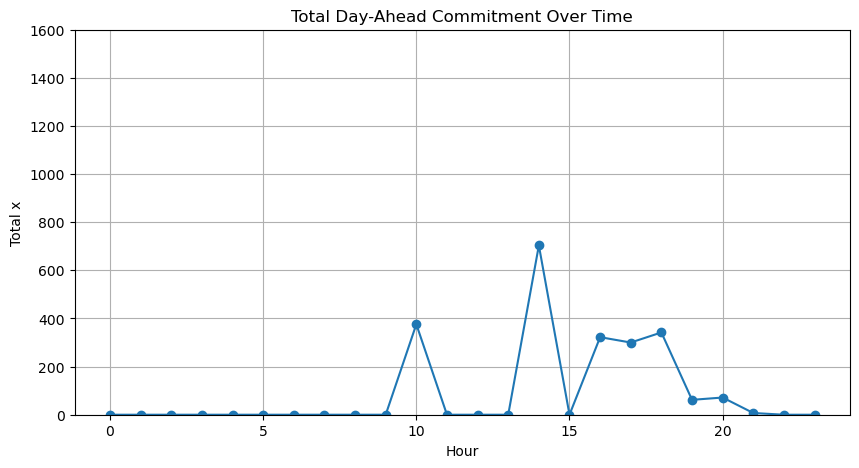

In [4]:
print("\n[AGG MODEL] Day-Ahead Commitment (alpha values):")
total_agg_commit = 0
for t in range(T):
    alpha_t = a[t].X
    total_agg_commit += alpha_t
    # print(f"Time {t}: {alpha_t:.2f}")
print(f"TOTAL: {total_agg_commit:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(range(T), a_vals, marker='o')
plt.title("Total Day-Ahead Commitment Over Time")
plt.xlabel("Hour")
plt.ylabel("Total x")
plt.ylim(0,1600)
plt.grid(True)
plt.show()

In [13]:
for s in range(1, 2):
    for t in range(T):
        sum_R = R[:, t, s].sum()
        alpha_val = a[t].X
        bp_val = bp[t, s].X
        bm_val = bm[t, s].X
        gc_val = gc[t, s].X
        gd_val = gd[t, s].X
        g_val = g[t, s].X

        lhs = sum_R - alpha_val
        rhs = bp_val - bm_val + gc_val - gd_val

        print(f"✅[t={t:02d}, s={s:02d}]  ∑R={sum_R:.2f}, α={alpha_val:.2f}, β⁺={bp_val:.2f}, β⁻={bm_val:.2f}, γᶜ={gc_val:.2f}, γᴰ={gd_val:.2f}, γ={g_val:.2f}")
        # print(f"              LHS = {lhs:.2f}, RHS = {rhs:.2f}")

✅[t=00, s=01]  ∑R=0.00, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=30.00
✅[t=01, s=01]  ∑R=0.00, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=30.00
✅[t=02, s=01]  ∑R=0.00, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=30.00
✅[t=03, s=01]  ∑R=0.00, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=30.00
✅[t=04, s=01]  ∑R=0.57, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.57, γᴰ=0.00, γ=30.00
✅[t=05, s=01]  ∑R=0.00, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=30.57
✅[t=06, s=01]  ∑R=4.68, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=4.68, γᴰ=0.00, γ=30.57
✅[t=07, s=01]  ∑R=5.40, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=5.40, γᴰ=0.00, γ=35.24
✅[t=08, s=01]  ∑R=52.12, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=52.12, γᴰ=0.00, γ=40.64
✅[t=09, s=01]  ∑R=126.47, α=0.00, β⁺=0.00, β⁻=0.00, γᶜ=126.47, γᴰ=0.00, γ=92.76
✅[t=10, s=01]  ∑R=365.04, α=375.97, β⁺=208.29, β⁻=0.00, γᶜ=0.00, γᴰ=219.23, γ=219.23
✅[t=11, s=01]  ∑R=177.75, α=0.00, β⁺=177.75, β⁻=0.00, γᶜ=0.00, γᴰ=0.00, γ=0.00
✅[t=12, s=01]  ∑R=693.80, α=0.00, β⁺=693.80, β⁻=0.00, γᶜ=0.00, γᴰ=0.00

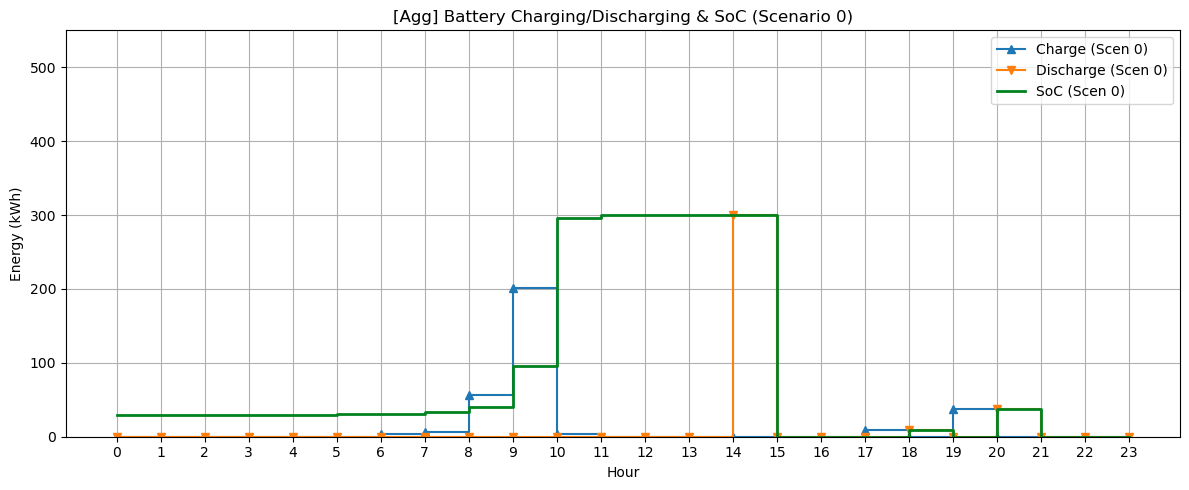

In [6]:
s = 0
gc_single = gc_vals[:, s]
gd_single = gd_vals[:, s]
g_single  = g_vals[:, s]
hours = np.arange(T)

plt.figure(figsize=(12, 5))
plt.step(hours, gc_single, where='post', label=f"Charge (Scen {s})", marker='^')
plt.step(hours, gd_single, where='post', label=f"Discharge (Scen {s})", marker='v')
plt.step(hours, g_single, where='post', label=f"SoC (Scen {s})", color='#00821E', linewidth=2)

plt.title(f"[Agg] Battery Charging/Discharging & SoC (Scenario {s})")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.xticks(hours)
plt.ylim(0, 550)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()